# Analyse version finale

## Import de la db

Cette fois on n'a accès qu'à la table "opinion", pas tout le site. On va fusionner ce jeu avec les infos de table extraits de la version précédente, notamment pour avoir les titres des thèmes du débat.

```bash
sudo mysql
```

```sql
create database gj;
use gj;
source opinion.sql;
select * from opinion into outfile "/mnt/k/Downloads/vraidebat/opinion_final.csv" fields enclosed by '"' terminated by ';' lines terminated by '\n';
```

On crée aussi le fichier `header2` manuellement, vu qu'il n'est toujours pas possible après 60 ans d'existence, d'exporter l'en-tête d'une table MySQL.

## Librairies

In [5]:
library(data.table)
library(tm)
library(stringi)
library(dbscan)
library(Rtsne)
library(RColorBrewer)
library(tm)
library(stringi)
library(textstem)
library(koRpus.lang.fr)
library(wordcloud)
library(text2vec)
library(gsubfn)
library(dendextend)
library(softmaxreg)
library(text2vec)
library(ldatuning)
library(topicmodels)
library(textstem)


Loading required package: NLP
Loading required package: koRpus.lang.en
Loading required package: koRpus
Loading required package: sylly
For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()

Loading required package: proto
Warning message:
“no DISPLAY variable so Tk is not available”
---------------------
Welcome to dendextend version 1.9.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: ‘dendextend’

The following object is masked from ‘package:data.table’:

    set

The following object is masked from ‘package:stats’:

 

## Lecture de la bdd

Ici on lit juste le fichier exporté, on le merge avec la catégorie d'opinion, et on corrige le vote: une proposition a le support de celui qui l'a postée, par définition.

In [6]:
d=fread("opinion_final.csv")

hd=fread("header2", header=F)$V1
colnames(d)=hd
optype=fread("opinion_type.csv", header=F)
d$optype=optype$V2[match(as.character(d$opinion_type), optype$V1)]

text=paste(d$title, d$body)


In [7]:
d$n_vote=d$vote_count_nok+d$vote_count_ok+d$vote_count_mitige
d$n_vote=d$n_vote+1
d$vote_count_ok=d$vote_count_ok+1
d$vote=d$vote_count_ok/d$n_vote

In [8]:
nrow(d)

[1] 25410

## Préparation

Basique (génère `docs_untrans`)
* transformation en minuscules
* suppression des balises HTML
* suppression des liens hypertexte
* suppression des caractères spéciaux HTML

Avancée
* suppression des "stop words"
* suppression de la ponctuation
* suppression du whitespace
* précorrection des fautes touchant des mots spécifiques 
* correction automatique avec hunspell
* création du dictionnaire de lemmatisation
* lemmatisation
* suppression des suggestions de lemmes alternatifs
* suppression des mots peu informatifs
* suppression des mots d'une ou deux lettres

In [9]:
removeLinks = function(string){
  return(gsub(" ?(f|ht)(tp)(s?)(://)(.*)[.|/](.*)", " ", string))  
}

removeChars <- function(htmlString) {
  return(gsub("&.*?;", " ", htmlString))
}


cleanFun <- function(htmlString) {
  return(gsub("<.*?>", " ", htmlString))
    
}



gj=Corpus(VectorSource(text))
docs=gj;
docs <- tm_map(docs, content_transformer(tolower))
docs=tm_map(docs, cleanFun)
docs=tm_map(docs, removeLinks)
docs=tm_map(docs, removeChars)
docs_untrans=docs
docs=tm_map(docs, removeWords, stopwords("french"))
replacePunctuation <- content_transformer(function(x) {return (gsub("[[:punct:]]"," ", x))})

docs=tm_map(docs, replacePunctuation)
docs=tm_map(docs, stripWhitespace)
selfcorr = c("sécurité", "sécurité", "", "", "économie", "économie", "kilomètre", "milliard", "agroalimentaire", "dioxyde", "", "référendum initiative citoyenne")
names(selfcorr)=c("sécu", "secu", "ème", "eme", "éco", "eco", "km", "mds", "agro", "co2", "ni", "ric")
selfcordict=split(unname(selfcorr),names(selfcorr))
replace_words=function(string, dict, i=length(dict)){
    if(i==1){return(gsub(paste0('\\b', names(dict)[1], '\\b'), dict[1], string))}
    else{return(gsub(paste0('\\b', names(dict)[i], '\\b'), dict[names(dict)[i]], replace_words(string, dict, i-1)))}    
}
replace_words_nothing=function(string, dict, i=length(dict)){
    if(i==1){return(gsub(paste0('\\b', dict[1], '\\b'), " ", string))}
    else{return(gsub(paste0('\\b', dict[1], '\\b'), " ", replace_words(string, dict, i-1)))}    
}


correction =function (x){
for (wd in setdiff(unlist(hunspell(x, dict="fr")), motsaufs)){
  x=gsub(paste0('\\b', wd, '\\b'), unlist(hunspell_suggest(wd, dict="fr"))[1] ,x)  
}
}
correct_text =function (content){paste(sapply(strsplit(tolower(content), " ", fixed=T)[[1]], correction), collapse=' ')}
corrected=tm_map(docs, tolower)
corrected=tm_map(corrected, replace_words, selfcorr)
corrected <- tm_map(corrected, removeNumbers)
docs=tm_map(docs, stripWhitespace)

lemdict=make_lemma_dictionary(corrected, engine="treetagger", lang="fr", path="/mnt/k/Downloads/vraidebat")

doclem=tm_map(corrected, lemmatize_strings, dictionary=lemdict)
stops=tm_map(doclem, removeWords, stopwords("french"))

mul=sapply(stops, function(x){grepl("\\|", x)})
wds=sapply(stops, function(x){grep('|', strsplit(x, " +")[[1]], fixed=T, value=T)})
removeLemmas=function(x){
    return(paste(strsplit(x, '|', fixed=T)[[1]], collapse=" "))
}
stops_noinc=stops
stops_noinc$content=sapply(stops, removeLemmas)

removeSmall= function(str){
    gsub('\\b\\w{1,2}\\s','',str)
}

stops_noinc$content=sapply(stops_noinc, removeSmall)
redondant=c("plus", "tout", "faire", "falloir", "devoir", "pouvoir", "être", "donc", "comme",
            "chaque","non", "autre" , "bien", "celui", "grand", "mettre")
stops_noinc=tm_map(stops_noinc, removeWords, redondant)

#i_lda=DocumentTermMatrix(stops_noinc[d$optype=="Justice, Police, Armée"])

# subs=d[d$optype=="Justice, Police, Armée", c("title", "body")]


Warning message in tm_map.SimpleCorpus(docs, content_transformer(tolower)):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(docs, cleanFun):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(docs, removeLinks):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(docs, removeChars):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(docs, removeWords, stopwords("french")):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(docs, replacePunctuation):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(docs, stripWhitespace):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(docs, tolower):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corrected, replace_words, selfcorr):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corrected, removeNumbers):
“transformation drops documents”Warning message in tm_ma

## Chargement des word loadings pré-entraînés

Ceci sert à générer une projection des données sur un espace sémantique, et permet de faire des liens tels que "Moscou est à la Russie ce que Berlin est à l'Allemagne".

Ce jeu de données est gracieusement mis à disposition par M. Fauconnier (http://fauconnier.github.io/). Il s'agit du corpus frWac (>1 milliard de textes), avec une limite d'au moins 50 occurrences, entraîné avec l'algorithme SKIP et projeté sur 700 dimensions.

Des sources académiques suggèrent d'utiliser l'annotation Part of Speech pour ne garder que les substantifs, dans notre cas il faudrait aussi garder les verbes. Par manque de temps pour effectuer la comparaison, on saute cette étape. Les performances devraient être similaires.

In [7]:
pretrain=fread("frWac_no_postag_no_phrase_700_skip_cut50.txt.clean")

On réalise la projection proprement dite (attention ces deux étapes sont très longues):

In [8]:
embed=wordEmbed(stops_noinc, dictionary=pretrain, meanVec=T)

On dispose maintenant d'une matrice $n\times700$, $n$ textes et 700 dimensions. Ces dimensions représentent tout l'espace sémantique possible entraîné par frWac. 

On réduit la dimension de 700 à 2 à l'aide de la méthode t-SNE (plus performante que la PCA pour des jeux de données aux structures subtiles). On supprime au passage les duplicats.

# Suppression des duplicats

### Enregistrement des résultats

Comme les deux étapes avant durent très longtemps, on sauve les embeddings.

#### Pour sauvegarder

In [14]:
saveRDS(embed, "wordEmbeddings.bin")

#### Pour restaurer

In [10]:
embed=readRDS("wordEmbeddings.bin")

### Continuing with duplicates

In [11]:
nrow(embed)
nrow(d)

[1] 25410

[1] 25410

In [12]:
# duplicates
dupidx=(1:nrow(embed))[duplicated(embed) | duplicated(embed, fromLast = TRUE)]
d$num=1:nrow(d)

In [13]:
#dups=d[dupidx, c("num","vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige", "optype","title", "body")]
dups=d[dupidx,]
dupemb=embed[dupidx,]
dupu=unique(embed[dupidx,])
out=data.frame()
outi=NULL

for(i in 1:nrow(dupu)){
    idx=(1:nrow(dupemb))[apply(dupemb, 1, function(x){return(all(as.numeric(x)==as.numeric(dupu[i,])))})]
    idxpr=idx[1]
    dups$n_vote[idxpr]=sum(dups$n_vote[idx])
    dups$vote_count_ok[idxpr]=sum(dups$vote_count_ok[idx])
    dups$vote_count_nok[idxpr]=sum(dups$vote_count_nok[idx])
    dups$vote_count_mitige[idxpr]=sum(dups$vote_count_mitige[idx])
    dups$vote[idxpr]=dups$vote_count_ok[idxpr]/dups$n_vote[idxpr]
    out=rbind(out,dups[idxpr])
    outi=c(outi,idxpr)
}
nrow(out)
length(outi)

[1] 140

[1] 140

In [14]:
d=d[-dupidx,]
d=rbind(d, out)
embedsave=dupemb[outi,]
embed=embed[-dupidx,]
embed=rbind(embed, embedsave)

In [15]:
nrow(d)
nrow(embed)

[1] 25233

[1] 25233

## Visualisation de l'ensemble des propositions avec t-SNE

Pour une raison inconnue il reste 1 duplicat:

In [12]:
u=apply(embed, 1, function(x){return(all(as.numeric(x)==as.numeric(embed[1,])))})
(1:nrow(embed))[u]

[1] 1

In [31]:
tsne=Rtsne(embed,dims=2, perplexity=50)

In [32]:
    saveRDS(tsne, "tSNE.all.perp50.bin")

In [26]:
tsne=readRDS( "tSNE.all.perp50.bin")

Une question : peut-on récapituler les grands thèmes à l'aide de la méthode t-SNE?

In [17]:
head(d$optype)

[1] "Démocratie, Institutions"                                                 
[2] "Economie, Finances, Travail, Compte public"                               
[3] "Economie, Finances, Travail, Compte public"                               
[4] "Justice, Police, Armée"                                                   
[5] "Démocratie, Institutions"                                                 
[6] "Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport"

png 
  2

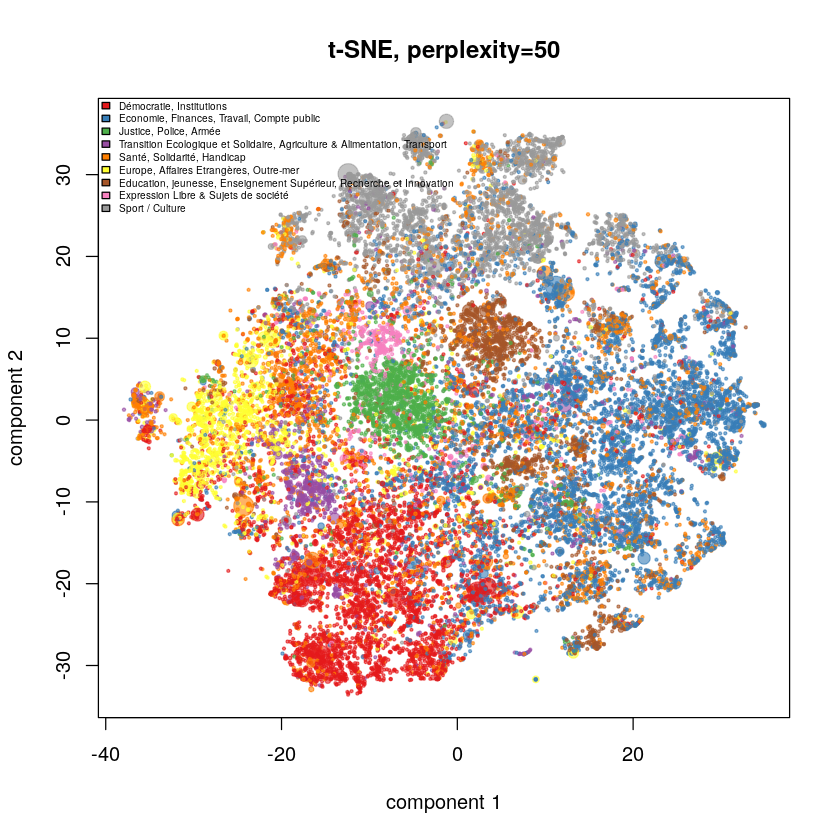

In [31]:

subs=d[, c("vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige", "optype","title", "body")]
subsi=subs

library(RColorBrewer)
pal=brewer.pal(length(unique(d$optype)), "Set1")

plot(tsne$Y, xlab="component 1", ylab="component 2", main="t-SNE, perplexity=50",
     pch=20, cex=0.5+4*(subsi$n_vote/max(subsi$n_vote)), col=adjustcolor(pal[as.numeric(as.factor(d$optype))], alpha=0.6))
legend(-41.5, 40, unique(d$optype), fill=pal, cex=0.5, bty="n")

pdf("tsne.all.perp50.pdf", width=10, height=10)
subs=d[, c("vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige", "optype","title", "body")]
subsi=subs

library(RColorBrewer)
pal=brewer.pal(length(unique(d$optype)), "Set1")

plot(tsne$Y, xlab="component 1", ylab="component 2", main="t-SNE, perplexity=50",
     pch=20, cex=0.5+4*(subsi$n_vote/max(subsi$n_vote)), col=adjustcolor(pal[as.numeric(as.factor(d$optype))], alpha=0.6))
legend(-41, 38, unique(d$optype), fill=pal, cex=0.5, bty="n")
dev.off()

Intéressant. On arrive bien à distinguer certains clusters, celui sur la Police/Armée ou celui sur la transition écologique est particulièrement distinct par exemple. D'autres se placent sur une sorte de gradient Sport-Démocratie-Europe. Essayons avec une perplexité plus faible, puis intermédiaire.

In [24]:
tsne=Rtsne(embed,dims=2, perplexity=5)


In [27]:
saveRDS(tsne, "tSNE.all.perp5.bin")

In [44]:
tsne=readRDS("tSNE.all.perp5.bin")

In [34]:
options(repr.plot.width=10, repr.plot.height=10)

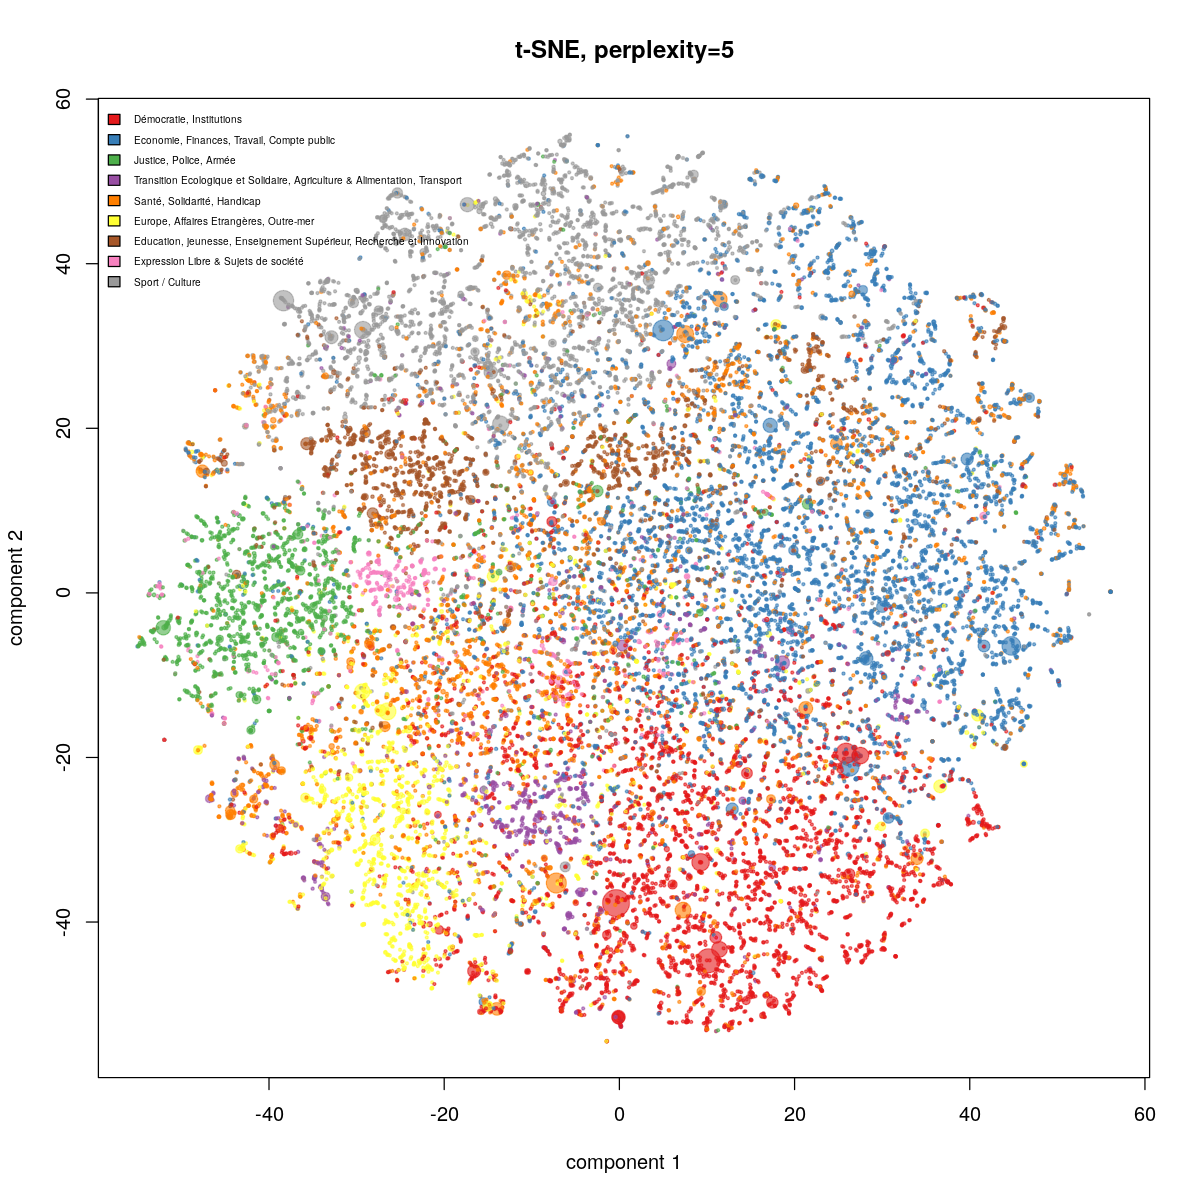

In [49]:
plot(tsne$Y, xlab="component 1", ylab="component 2", main="t-SNE, perplexity=5", 
     pch=20, cex=0.5+4*(subsi$n_vote/max(subsi$n_vote)), col=adjustcolor(pal[as.numeric(as.factor(d$optype))], alpha=0.6))
legend(-60, 60, unique(d$optype), fill=pal, cex=0.5, bty="n")

In [50]:
tsne=Rtsne(embed,dims=2, perplexity=10)


In [55]:
saveRDS(tsne, "tSNE.all.perp10.bin")

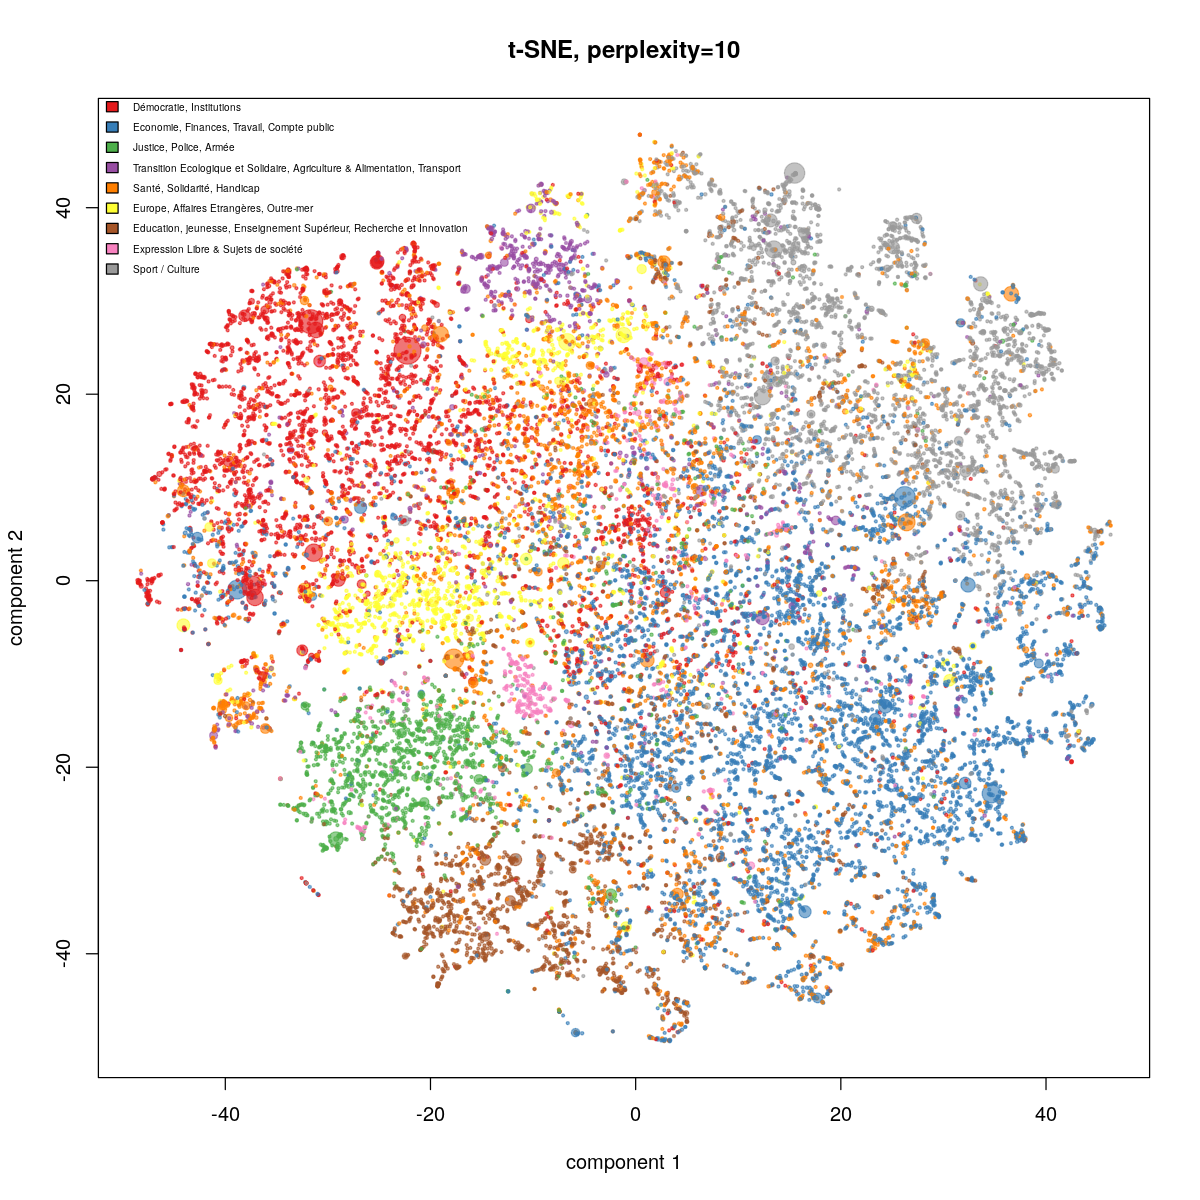

In [54]:
plot(tsne$Y, xlab="component 1", ylab="component 2", main="t-SNE, perplexity=10", 
     pch=20, cex=0.5+4*(subsi$n_vote/max(subsi$n_vote)), col=adjustcolor(pal[as.numeric(as.factor(d$optype))], alpha=0.6))
legend(-53, 53, unique(d$optype), fill=pal, cex=0.5, bty="n")

Avec des perplexités plus faibles, on a plus ou moins la même structure, avec une clusterisation un peu moins marquée. Les résultats sont donc remarquablement homogènes. Observons la clusterisation stratifiée par thème.

# Identification des sujets par sous-thème

On commence par les plus facilement identifiables. Attention cette fois on colore par approbation:

## Justice, Police, Armée

In [16]:
subs=d[d$optype=="Justice, Police, Armée", c("vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige", "optype","title", "body")]

In [17]:
tsne=Rtsne(embed[d$optype=="Justice, Police, Armée",],dims=2, perplexity=5)

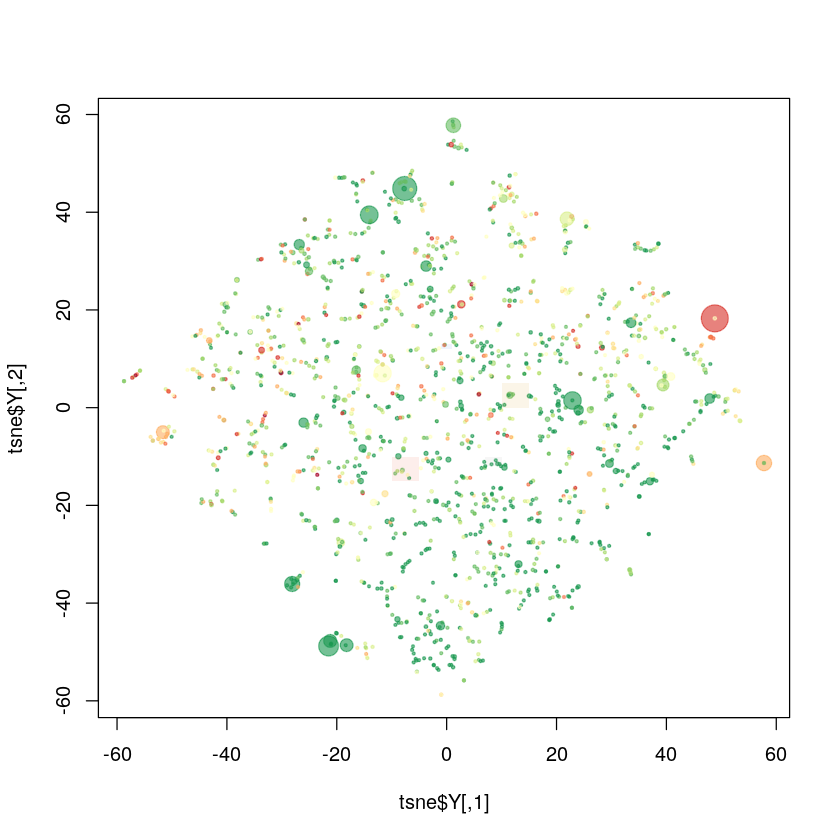

In [18]:
library(RColorBrewer)
subsi=subs
pal=brewer.pal(11, "RdYlGn")
subsi$votecat=pal[as.numeric(cut(subsi$vote, seq(-0.00001,1, length.out=11)))]

plot(tsne$Y, pch=20, cex=0.5+4*(subsi$n_vote/max(subsi$n_vote)), col=adjustcolor(subsi$votecat, alpha=0.6))
rect(xleft=10, xright=15, ybottom=0, ytop=5, col=adjustcolor("goldenrod", alpha=0.1), border=NA)
rect(xleft=-10, xright=-5, ybottom=-15, ytop=-10, col=adjustcolor("tomato2", alpha=0.1), border=NA)
rect(xleft=-1, xright=1, ybottom=12, ytop=13, col=adjustcolor("cornflowerblue", alpha=0.1), border=NA)
rect(xleft=7, xright=10, ybottom=-12, ytop=-10, col=adjustcolor("darkgray", alpha=0.1), border=NA)


In [19]:
subs$tsneX=tsne$Y[,1]
subs$tsneY=tsne$Y[,2]
subs$ptcol=adjustcolor(subsi$votecat, alpha=0.6)
subs$ptcex=0.5+4*(subsi$n_vote/max(subsi$n_vote))

In [20]:
fwrite(subs, "Police.csv", sep=",")

In [151]:
library(shiny)
library(DT)
library(plotly)
library(crosstalk)

m=subs %>% 
  tibble::rownames_to_column()

ui <- fluidPage(
  plotlyOutput("x2"),
    fluidRow(
          textOutput("x3")
  ),
    fluidRow(
    h4(textOutput("summary"), align="center")
  ),
  DT::dataTableOutput("x1")
)

server <- function(input, output) {

  d <- SharedData$new(m, ~rowname)

    output$x3=renderText({
        ss <- input$x1_rows_selected
        selbodies=((m[d$selection(),"body"])[ss])
        s=(1:nrow(m))[m$body %in% selbodies]
        paste(s)
    })
  # highlight selected rows in the scatterplot
  output$x2 <- renderPlotly({

        ss <- input$x1_rows_selected
        selbodies=((m[d$selection(),"body"])[ss])
        s=(1:nrow(m))[m$body %in% selbodies]

    if (!length(s)) {
      p <- d %>%
        plot_ly(x = ~tsneX, y = ~tsneY, mode = "markers", color = ~vote, 
                colors=rev(adjustcolor(c("forestgreen", "goldenrod", "firebrick"), alpha=0.7)), size=~n_vote, name = 'Unfiltered') %>%
        layout(showlegend = T) %>% 
        highlight("plotly_selected", color = I('red'), selected = attrs_selected(name = 'Filtered'))
    } else if (length(s)) {
      pp <- m %>%
        plot_ly() %>% 
        add_trace(x = ~tsneX, y = ~tsneY, mode = "markers", color = ~vote, 
                colors=rev(adjustcolor(c("forestgreen", "goldenrod", "firebrick"), alpha=0.7)), size=~n_vote, name = 'Unfiltered') %>%
        layout(showlegend = T)

      # selected data
      pp <- add_trace(pp, data = m[s, , drop = F], x = ~tsneX, y = ~tsneY, mode = "markers",
                      color = I('red'), name = 'Filtered')
    }

  })

  # highlight selected rows in the table
  output$x1 <- DT::renderDataTable({
    m[d$selection(), c("vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige","title", "body"), drop=F]
#    dt <- DT::datatable(m)
#    if (NROW(m2) == 0) {
#      dt
#    } else {
#      DT::formatStyle(dt, "rowname", target = "row",
#                      color = DT::styleEqual(m2$rowname, rep("white", length(m2$rowname))),
#                      backgroundColor = DT::styleEqual(m2$rowname, rep("black", length(m2$rowname))))
#    }
  })

  # download the filtered data
  output$summary <- renderText({ 
    paste((input$x1)$title[1],"Total votes : ", sum(m[d$selection(),]$n_vote), "     Approbation : ", round(sum(m[d$selection(),]$n_vote*m[d$selection(),]$vote)/sum(m[d$selection(),]$n_vote)*100), "%")
  })
#     output$x3 = downloadHandler('mtcars-filtered.csv', content = function(file) {
#     s <- input$x1_rows_selected
#     if (length(s)) {
#       write.csv(m[s, , drop = FALSE], file)
#     } else if (!length(s)) {
#       write.csv(m[d$selection(),], file)
#     }
#   })

}

shinyApp(ui, server)


Listening on http://127.0.0.1:4635
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warnin

Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default 

No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not cu

80% 
 37

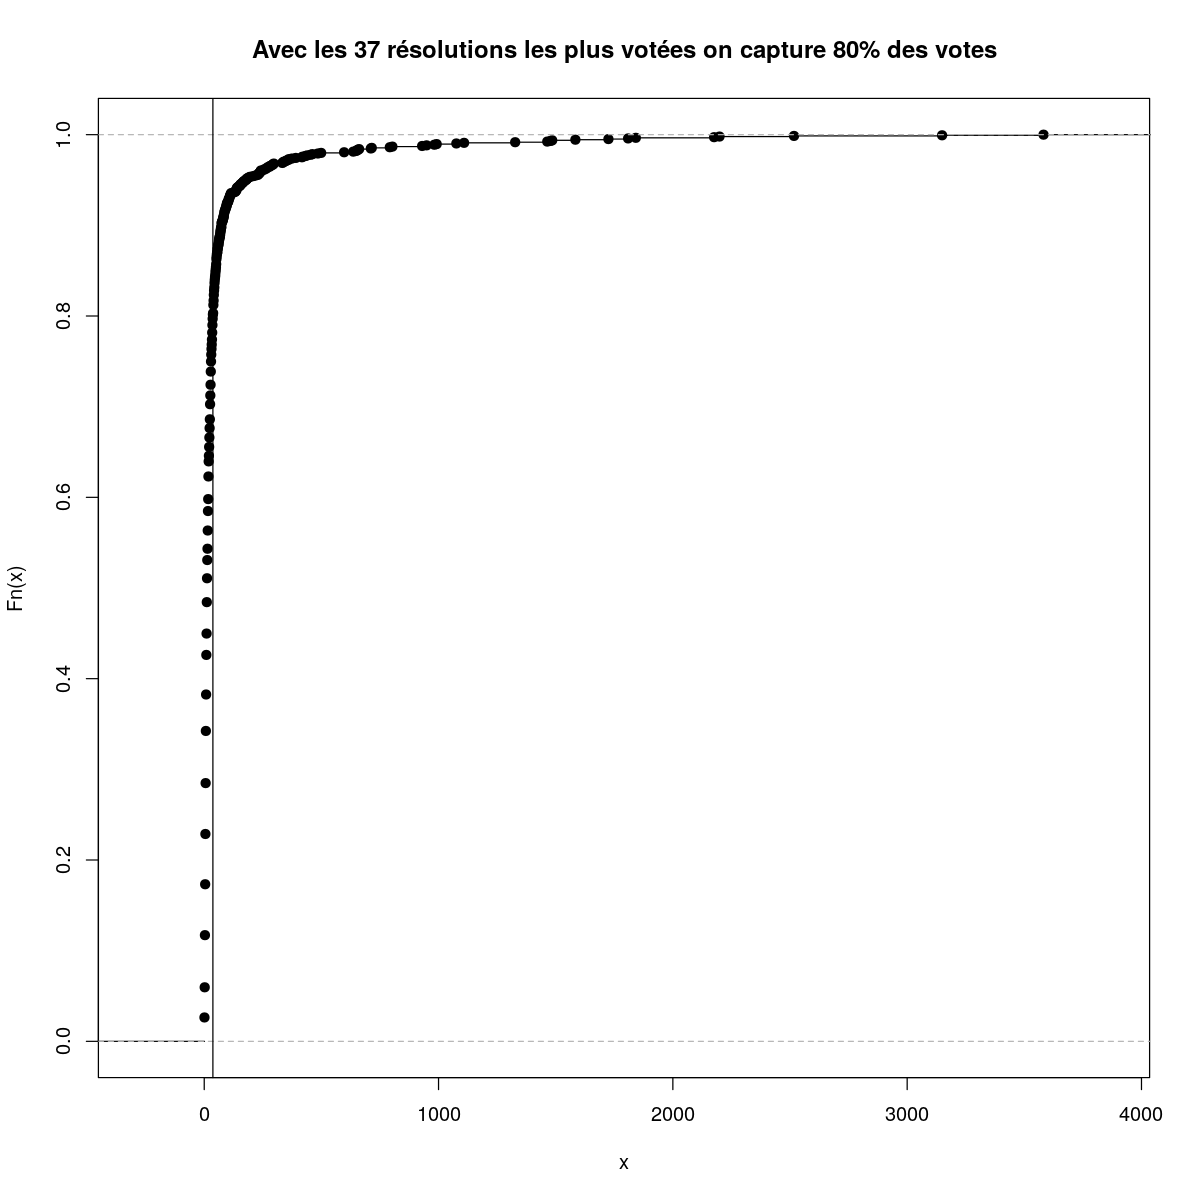

In [150]:
h=ecdf(subs[subs$vote>0.6 | subs$vote<0.5,]$n_vote)
plot(h, main="Avec les 37 résolutions les plus votées on capture 80% des votes")
quantile(subs[subs$vote>0.6 | subs$vote<0.5,]$n_vote, 0.8)
abline(v=37)

In [148]:
sum(subs[subs$vote>0.6 | subs$vote<0.5,]$n_vote)

[1] 81536

In [152]:
unique(d$optype)

[1] "Démocratie, Institutions"                                                 
[2] "Economie, Finances, Travail, Compte public"                               
[3] "Justice, Police, Armée"                                                   
[4] "Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport"
[5] "Santé, Solidarité, Handicap"                                              
[6] "Europe, Affaires Etrangères, Outre-mer"                                   
[7] "Education, jeunesse, Enseignement Supérieur, Recherche et Innovation"     
[8] "Expression Libre & Sujets de société"                                     
[9] "Sport / Culture"

## Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport

In [14]:
subs=d[d$optype=="Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport", c("vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige", "optype","title", "body")]
tsne=Rtsne(embed[d$optype=="Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",],dims=2, perplexity=5)

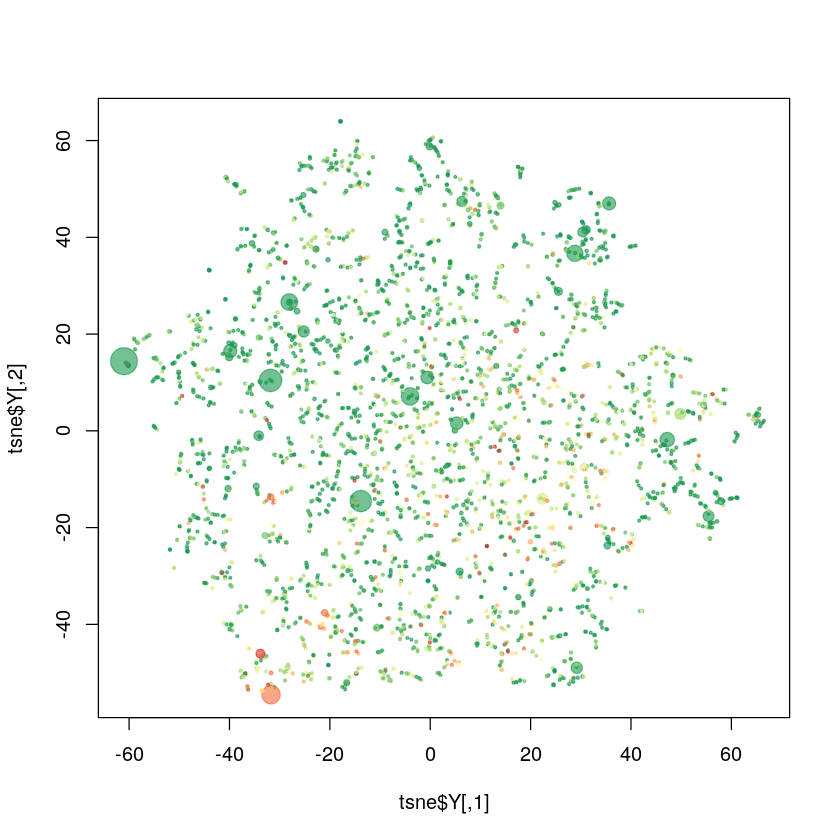

In [15]:
library(RColorBrewer)

subsi=subs
pal=brewer.pal(11, "RdYlGn")
subsi$votecat=pal[as.numeric(cut(subsi$vote, seq(-0.00001,1, length.out=11)))]

plot(tsne$Y, pch=20, cex=0.5+4*(subsi$n_vote/max(subsi$n_vote)), col=adjustcolor(subsi$votecat, alpha=0.6))

In [16]:
head(subs)

vote,n_vote,vote_count_ok,vote_count_nok,vote_count_mitige,optype,title,body
0.9333333,15,14,0,1,"Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",Grand plan d'aménagement et d'utilisation des voies navigables pour le transport des marchandises,<p>Nous avons tout un réseau de voies navigables dont nous ne tirons pas profit.</p>
0.8000000,5,4,1,0,"Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",TARIFS PROGRESSIFS POUR L'ÉLECTRICITÉ ET L'EAU,"<p>Des tarifs progressifs pour l'eau et l'électricité (ou autres énergies) semblent un bon moyen de lutter contre le gaspillage, tout en permettant aux plus vertueux et aux revenus les plus modestes de bénéficier de tarifs pratiquement à prix coûtant</p>"
0.6000000,10,6,3,1,"Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",favoriser les produits bios,"<p>Taxer encore plus les produits non bios, baisser la TVA sur les bios, obliger les cantines scolaires à aller vers \""tous les jours bio\"" et pas seulement 1 jour. Chaque année on rajouterait 1 jour de plus bio jusqu'à arriver à 5 ou 6 selon les établissements le temps de permettre la transition avec l'agriculture. Développer les coopératives bios de proximité. Ne pas importer de produits non bios ou augmenter fortement les taxes d'importation, augmenter aussi les contrôles. Expliquer aux enfants les bénéfices.</p><p>Développer l'herboristerie bio en recréant un diplôme français, l'acupuncture, une autre médecine qui prenne en compte le patient dans son ensemble.</p><p>Pour financer ces mesures il faudrait prendre là où est l'argent, par exemple instaurer une nouvelle taxe sur les produits chimiques destinés à l'agriculture (engrais, pesticides, herbicides, graines transgéniques résistantes )</p>"
0.5625000,16,9,7,0,"Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",Sortir du nucléaire,<p>Sortir du nucléaire</p>
0.5000000,6,3,1,2,"Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",vrai alternative énergétique,"<p>avant de taxer le diesel ou le fioul pour se chauffer , il faudrait trouver une vrai alternative comme peut être hydrogène , éthanol ), car si demain tout le monde se chauffe et roule électrique , le réseau ne va pas supporter la consommation et de + il faudrait combien de centrales nucléaires en + , et la voiture électrique a une autonomie très faible donc juste pour rouler localement , la quantité de lithium ou autre pour fabriquer ces batteries sera énorme et deviendra très cher sans oublier la longévité , et le coût des pannes qui pourrais en résulter , comme la sécurité pour les voitures ( air-bag et abs ) les constructeurs avec l'état devraient équiper les nouveaux véhicules sans forcer à changer ou punir ceux qui ont des voitures plus anciennes. </p>"
1.0000000,4,4,0,0,"Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",Camion et ferroutage,"<p>Mettre en œuvre un véritable plan coercitif de transport des camions longues distances par ferroutage, taxation mortel pour les transports internationaux</p>"


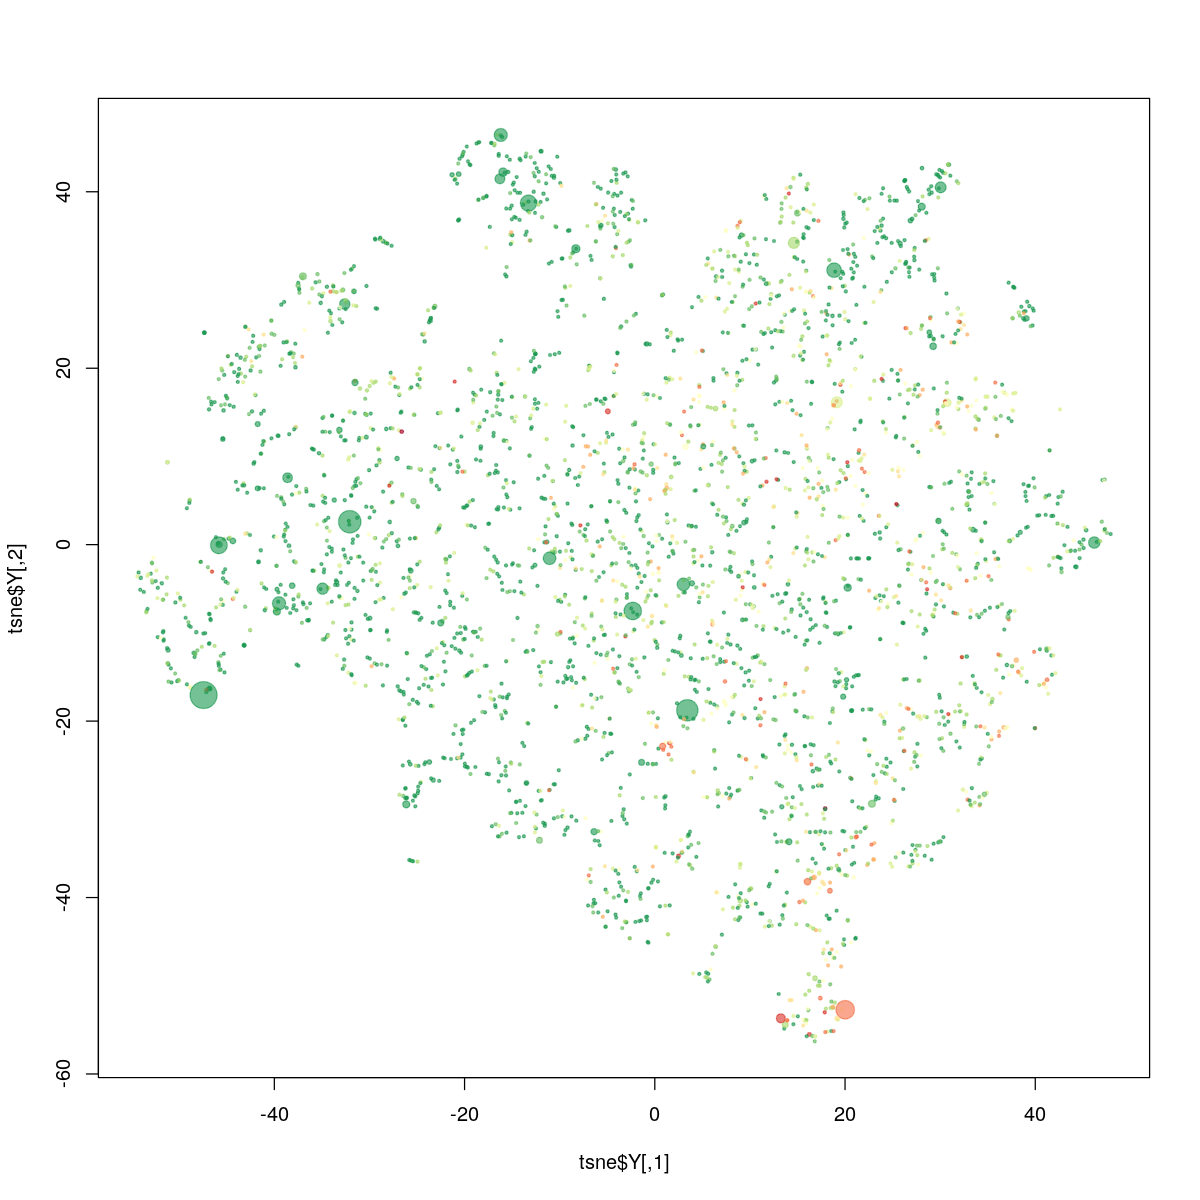

In [156]:
tsne=Rtsne(embed[d$optype=="Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",],dims=2, perplexity=10)
plot(tsne$Y, pch=20, cex=0.5+4*(subsi$n_vote/max(subsi$n_vote)), col=adjustcolor(subsi$votecat, alpha=0.6))

## Première version de l'outil (R Shiny + plotly)

In [164]:
library(shiny)
library(DT)
library(plotly)
library(crosstalk)

m=subs %>% 
  tibble::rownames_to_column()

ui <- fluidPage(
  plotlyOutput("x2"),
    fluidRow(
          textOutput("x3")
  ),
    fluidRow(
    h4(textOutput("summary"), align="center")
  ),
  DT::dataTableOutput("x1")
)

server <- function(input, output) {

  d <- SharedData$new(m, ~rowname)

    output$x3=renderText({
        ss <- input$x1_rows_selected
        selbodies=((m[d$selection(),"body"])[ss])
        s=(1:nrow(m))[m$body %in% selbodies]
        paste(s)
    })
  # highlight selected rows in the scatterplot
  output$x2 <- renderPlotly({

        ss <- input$x1_rows_selected
        selbodies=((m[d$selection(),"body"])[ss])
        s=(1:nrow(m))[m$body %in% selbodies]

    #if (!length(selbodies)) {
      p =plot_ly(data=d, x = ~tsneX, y = ~tsneY, mode = "markers", color = ~vote, 
                colors=rev(adjustcolor(c("forestgreen", "goldenrod", "firebrick"), alpha=0.7)), size=~n_vote) %>% 
        highlight("plotly_selected", color = I('red'))
#     } else  {
#       pp <- m %>%
#         plot_ly() %>% 
#         add_trace(x = ~tsneX, y = ~tsneY, mode = "markers", color = ~vote, 
#                 colors=rev(adjustcolor(c("forestgreen", "goldenrod", "firebrick"), alpha=0.7)), size=~n_vote, name = 'Unfiltered') %>%
#         highlight("plotly_selected", color = I('red'))

#       # selected data
#       pp <- add_trace(pp, data = m[s, , drop = F], x = ~tsneX, y = ~tsneY, mode = "markers",
#                       color = I('red'), name = 'Filtered')
#     }

  })

  # highlight selected rows in the table
  output$x1 <- DT::renderDataTable({
    m[d$selection(), c("vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige","title", "body"), drop=F]
#    dt <- DT::datatable(m)
#    if (NROW(m2) == 0) {
#      dt
#    } else {
#      DT::formatStyle(dt, "rowname", target = "row",
#                      color = DT::styleEqual(m2$rowname, rep("white", length(m2$rowname))),
#                      backgroundColor = DT::styleEqual(m2$rowname, rep("black", length(m2$rowname))))
#    }
  })

  # download the filtered data
  output$summary <- renderText({ 
    paste((input$x1)$title[1],"Total votes : ", sum(m[d$selection(),]$n_vote), "     Approbation : ", round(sum(m[d$selection(),]$n_vote*m[d$selection(),]$vote)/sum(m[d$selection(),]$n_vote)*100), "%")
  })
#     output$x3 = downloadHandler('mtcars-filtered.csv', content = function(file) {
#     s <- input$x1_rows_selected
#     if (length(s)) {
#       write.csv(m[s, , drop = FALSE], file)
#     } else if (!length(s)) {
#       write.csv(m[d$selection(),], file)
#     }
#   })

}

shinyApp(ui, server)


Listening on http://127.0.0.1:4635
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warning message:
“`line.width` does not currently support multiple values.”Setting the `off` event (i.e., 'plotly_deselect') to match the `on` event (i.e., 'plotly_selected'). You can change this default via the `highlight()` function.
No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter
Warnin

Malheureusement, cette version n'est pas très performante, la combinaison Shiny+Plotly n'est pas aussi flexible que Bokeh.

## Deuxième version avec `bokeh`

In [22]:

dic=cbind(unique(d$optype), c("Démocratie", "Economie", "Police", "Ecologie", "Santé", "Europe", "Education", "Libre", "Culture"))

In [24]:
for(s in dic[,1]){
    subs=d[d$optype==s, c("vote","n_vote","vote_count_ok", "vote_count_nok", "vote_count_mitige", "optype","title", "body")]
    tsne=Rtsne(embed[d$optype==s,],dims=2, perplexity=5)
    fn=paste(dic[dic[,1]==s,2], ".csv", sep="")
    subsi=subs
    pal=brewer.pal(11, "RdYlGn")
    subsi$votecat=pal[as.numeric(cut(subsi$vote, seq(-0.00001,1, length.out=11)))]
    subs$tsneX=tsne$Y[,1]
    subs$tsneY=tsne$Y[,2]
    subs$ptcol=adjustcolor(subsi$votecat, alpha=0.6)
    subs$ptcex=0.5+4*(subsi$n_vote/max(subsi$n_vote))
    fwrite(subs, fn, sep=",")
}

La suite est en Python dans le notebook [Visualisation-Outil.html](Visualisation-Outil.html).

## Intervalles de confiance pour la proportion

In [7]:
library(data.table)
df=fread("Démocratie.csv")
p_prop=apply(df, 1, function(x){binom.test(round(as.numeric(x["vote"]) * as.numeric(x["n_vote"])), as.numeric(x["n_vote"]))$p.value})

In [13]:
df$p_prop=p_prop

In [14]:
    fwrite(df, "Démocratie.p.csv", sep=",")


Fonctionne bien. On généralise pour tous les fichiers dans le répertoire `app/`.

In [4]:
library(data.table)
th=c("Démocratie", "Economie", "Police", "Ecologie", "Santé", "Europe", "Education", "Libre", "Culture")
for( t in th){
t=paste0(t, ".csv")
df=fread(file=t)
df$p_prop=apply(df, 1, function(x){binom.test(round(as.numeric(x["vote"]) * as.numeric(x["n_vote"])), as.numeric(x["n_vote"]))$p.value})
fwrite(df, paste0("apps/", t), sep=",")
}